# 1.0 Full Exploratory Data Analysis

## Libraries

In [8]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
import final_project.utils.paths as path
import janitor
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

## Download data

### Specify input and output files

In [10]:
covid_url = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv"

covid_file = path.data_raw_dir("time_series_covid19_confirmed_global.csv")

### Run download

In [11]:
!curl {covid_url} -o {covid_file}

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1629k  100 1629k    0     0   970k      0  0:00:01  0:00:01 --:--:--  969k


## Process data

### Read data

In [12]:
input_covid_file = path.data_raw_dir("time_series_covid19_confirmed_global.csv")

In [13]:
covid_df = pd.read_csv(input_covid_file)
covid_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 289 entries, 0 to 288
Columns: 1067 entries, Province/State to 12/19/22
dtypes: float64(2), int64(1063), object(2)
memory usage: 2.4+ MB


In [14]:
covid_df.head()

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,12/10/22,12/11/22,12/12/22,12/13/22,12/14/22,12/15/22,12/16/22,12/17/22,12/18/22,12/19/22
0,NaN,Afghanistan,33.93911,67.709953,0,0,0,0,0,0,...,206543,206603,206702,206743,206788,206879,206912,206943,207037,207084
1,NaN,Albania,41.15330,20.168300,0,0,0,0,0,0,...,333521,333533,333535,333567,333591,333613,333635,333635,333650,333653
2,NaN,Algeria,28.03390,1.659600,0,0,0,0,0,0,...,271146,271146,271147,271149,271156,271156,271156,271168,271174,271179
3,NaN,Andorra,42.50630,1.521800,0,0,0,0,0,0,...,47446,47446,47446,47446,47606,47606,47606,47606,47606,47606
4,NaN,Angola,-11.20270,17.873900,0,0,0,0,0,0,...,104808,104808,104808,104808,104946,104946,104946,104946,104946,104946


### Process data

In [15]:
processed_df = (
    covid_df
    .select_columns(["Country/Region", "*/*/*"])
    .pivot_longer(
        index="Country/Region",
        names_to="date"
    )
    .transform_column("date", pd.to_datetime)
    .clean_names()
)

processed_df.head()

,country_region,date,value
0,Afghanistan,2020-01-22,0
1,Albania,2020-01-22,0
2,Algeria,2020-01-22,0
3,Andorra,2020-01-22,0
4,Angola,2020-01-22,0


### Save output data

In [16]:
output_covid_file = path.data_processed_dir("time_series_covid19_confirmed_global_processed.csv")

In [17]:
processed_df.to_csv(output_covid_file, index=False)

## Explore data

### Read data

In [18]:
processed_covid_file = path.data_processed_dir("time_series_covid19_confirmed_global_processed.csv")

In [19]:
processed_covid_df = pd.read_csv(processed_covid_file)
processed_covid_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 307207 entries, 0 to 307206
Data columns (total 3 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   country_region  307207 non-null  object
 1   date            307207 non-null  object
 2   value           307207 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 7.0+ MB


In [20]:
processed_covid_df.head()

,country_region,date,value
0,Afghanistan,2020-01-22,0
1,Albania,2020-01-22,0
2,Algeria,2020-01-22,0
3,Andorra,2020-01-22,0
4,Angola,2020-01-22,0


### Explore data

In [21]:
sns.set_style("whitegrid")

In [22]:
processed_covid_df = (
    processed_covid_df
    .transform_column(
        "date",
        pd.to_datetime
    )
)

#### Appearance of new covid-19 cases in Latam

Subset data.

In [23]:
countries = ['Argentina', 'Brazil', 'Chile', 'Colombia', 'Mexico', 'Peru']
some_latam_countries_df = processed_covid_df.filter_on(f"country_region in {countries}")
some_latam_countries_df.head(3)

,country_region,date,value
7,Argentina,2020-01-22,0
31,Brazil,2020-01-22,0
58,Chile,2020-01-22,0


Plot time series.

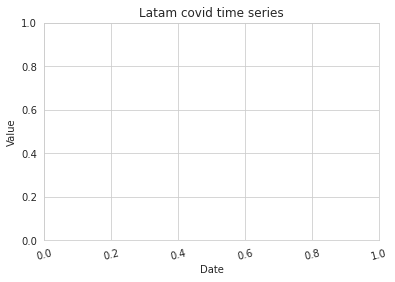

In [35]:
import final_project.visualization.visualize as visualize

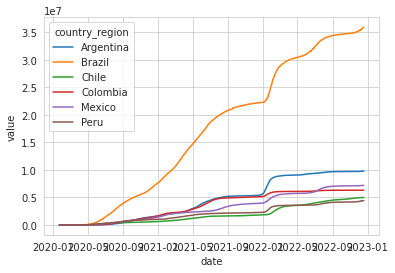

In [36]:
visualize.covid_time_series(some_latam_countries_df)

#### Latam in global context

Top `n` countries.

In [25]:
top_countries_df = (
    processed_covid_df
    .select_columns(["country_region", "value"])
    .groupby(["country_region"])
    .aggregate("sum")
    .sort_values("value", ascending=False)
    .reset_index()
    .head(20)
    .transform_column(
        column_name="country_region",
        function=lambda x: "red" if x in countries else "lightblue",
        dest_column_name="color"
    )
)

top_countries_df.head()

,country_region,value,color
0,US,45642480757,lightblue
1,India,25556418006,lightblue
2,Brazil,18245142677,red
3,France,12932054384,lightblue
4,Germany,10695398018,lightblue


Plot to Latam in highlighted bars.

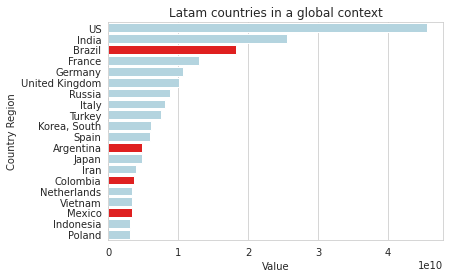

In [26]:
sns.barplot(
    data=top_countries_df,
    x="value",
    y="country_region",
    palette=top_countries_df.color
)

plt.xlabel("Value")
plt.ylabel("Country Region")
plt.title("Latam countries in a global context");